In [1]:
import typing as tp

import torch
import torch.nn as nn
import torch.optim as optim
import dataset
import pandas as pd

from torch.utils.data import DataLoader
from tqdm import tqdm

from utils import Settings, Clothes, seed_everything
from vit import ViT

from run_epoch import get_vit_model, get_loaders

In [2]:
import time
import json
import os
import threading
import torch
from enum import Enum
from collections import defaultdict

class Phase(Enum):
    WAIT = 0
    WARMUP = 1
    ACTIVE = 2

class Schedule:
    def __init__(self, wait, warmup, active):
        self.wait = wait
        self.warmup = warmup
        self.active = active
        self.cycle = wait + warmup + active

    def phase(self, step):
        s = step % self.cycle
        if s < self.wait:
            return Phase.WAIT
        if s < self.wait + self.warmup:
            return Phase.WARMUP
        return Phase.ACTIVE

def schedule(*, wait=0, warmup=0, active=1):
    return Schedule(wait, warmup, active)

class Profile:
    def __init__(self, model, schedule):
        self.model = model
        self.schedule = schedule
        self.step_idx = -1
        self.events = []
        self.open = {}
        self.hooks = []
        self.pid = os.getpid()
        self.tid = threading.get_native_id()

    def __enter__(self):
        self._register()
        return self

    def __exit__(self, exc_type, exc, tb):
        for h in self.hooks:
            h.remove()

    def step(self):
        self.step_idx += 1

    def _enabled(self):
        return self.schedule.phase(self.step_idx) == Phase.ACTIVE

    def _ts(self):
        return time.time_ns() / 1000

    def _record(self, name, cat, ph):
        if ph == "B":
            self.open[(name, cat)] = self._ts()
        else:
            start = self.open.pop((name, cat))
            self.events.append((name, cat, self._ts() - start))

    def _register(self):
        for name, m in self.model.named_modules():
            if len(list(m.children())) == 0:
                self.hooks.append(m.register_forward_pre_hook(self._forward_pre_hook(name)))
                self.hooks.append(m.register_forward_hook(self._forward_post_hook(name)))
                self.hooks.append(m.register_full_backward_pre_hook(self._backward_pre_hook(name)))
                self.hooks.append(m.register_full_backward_hook(self._backward_post_hook(name)))

    def _forward_pre_hook(self, name):
        def h(m, i):
            if self._enabled():
                self._record(name, "forward", "B")
        return h

    def _forward_post_hook(self, name):
        def h(m, i, o):
            if self._enabled():
                if o.is_cuda:
                    torch.cuda.synchronize()
                self._record(name, "forward", "E")
        return h

    def _backward_pre_hook(self, name):
        def h(m, g):
            if self._enabled():
                self._record(name, "backward", "B")
        return h

    def _backward_post_hook(self, name):
        def h(m, gi, go):
            if self._enabled():
                if any(t is not None and t.is_cuda for t in go):
                    torch.cuda.synchronize()
                self._record(name, "backward", "E")
        return h

    def to_perfetto(self, path="trace.json"):
        if not self.events:
            return

        buckets = defaultdict(list)
        for name, cat, dur in self.events:
            buckets[(name, cat)].append(dur)

        avg = {k: sum(v) / len(v) for k, v in buckets.items()}

        ts = 0
        trace_events = []
        for (name, cat), dur in avg.items():
            trace_events.append({
                "name": f"{name}:{cat}",
                "ph": "X",
                "ts": ts,
                "dur": dur,
                "pid": self.pid,
                "tid": self.tid
            })
            ts += dur

        trace = {
            "traceEvents": [
                {
                    "name": "process_name",
                    "ph": "M",
                    "pid": self.pid,
                    "args": {"name": "Averaged Layer Profiler"}
                }
            ] + trace_events
        }

        with open(path, "w") as f:
            json.dump(trace, f)


In [3]:
def run_epoch(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    epoch_loss, epoch_accuracy = 0.0, 0.0

    with Profile(
        model,
        schedule=schedule(wait=2, warmup=1, active=3),
    ) as prof:
        for data, label in tqdm(train_loader, desc="Train"):
            data = data.to(Settings.device)
            label = label.to(Settings.device)

            output = model(data)
            loss = criterion(output, label)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc.item() / len(train_loader)
            epoch_loss += loss.item() / len(train_loader)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            prof.step()
        prof.to_perfetto()

    model.eval()
    val_loss, val_accuracy = 0.0, 0.0

    for data, label in tqdm(val_loader, desc="Val"):
        data = data.to(Settings.device)
        label = label.to(Settings.device)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, label)

        acc = (output.argmax(dim=1) == label).float().mean()
        val_accuracy += acc.item() / len(val_loader)
        val_loss += loss.item() / len(val_loader)

    

    return epoch_loss, epoch_accuracy, val_loss, val_accuracy

In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch(model, train_loader, val_loader, criterion, optimizer)

![Screenshot from 2026-02-07 22-44-21.png](<attachment:Screenshot from 2026-02-07 22-44-21.png>)
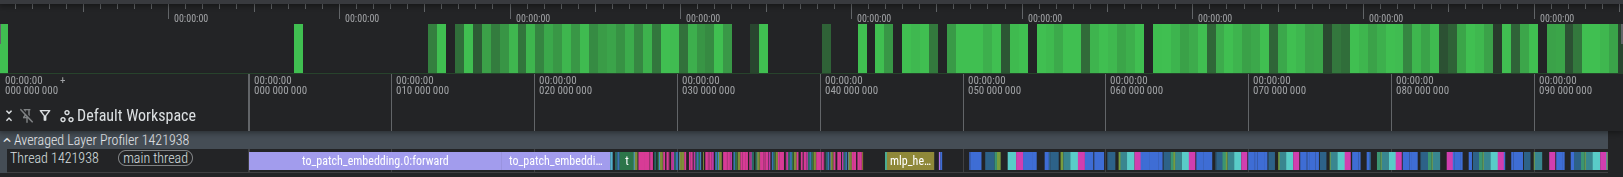

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

def run_epoch_torch_profiler(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    epoch_loss, epoch_accuracy = 0.0, 0.0

    warmup_steps = 3
    active_steps = 1

    data_iter = iter(train_loader)
    for _ in range(warmup_steps):
        data, label = next(data_iter)
        data = data.to(Settings.device)
        label = label.to(Settings.device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    torch.cuda.synchronize()

    with profile(
        activities=[ProfilerActivity.CUDA],
        record_shapes=False,
        with_stack=False,
        profile_memory=False,
        on_trace_ready=lambda p: p.export_chrome_trace(
            "torch_profiler_trace.json"
        ),
    ) as prof:

        for _ in range(active_steps):
            data, label = next(data_iter)
            data = data.to(Settings.device)
            label = label.to(Settings.device)

            with record_function("forward"):
                output = model(data)
                loss = criterion(output, label)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc.item() / len(train_loader)
            epoch_loss += loss.item() / len(train_loader)

            optimizer.zero_grad()

            with record_function("backward"):
                loss.backward()

            with record_function("optimizer"):
                optimizer.step()

            prof.step()

    model.eval()
    val_loss, val_accuracy = 0.0, 0.0

    for data, label in val_loader:
        data = data.to(Settings.device)
        label = label.to(Settings.device)

        with torch.no_grad():
            output = model(data)
            loss = criterion(output, label)

        acc = (output.argmax(dim=1) == label).float().mean()
        val_accuracy += acc.item() / len(val_loader)
        val_loss += loss.item() / len(val_loader)

    return epoch_loss, epoch_accuracy, val_loss, val_accuracy


In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch_torch_profiler(model, train_loader, val_loader, criterion, optimizer)


![image copy.png](<attachment:image copy.png>)
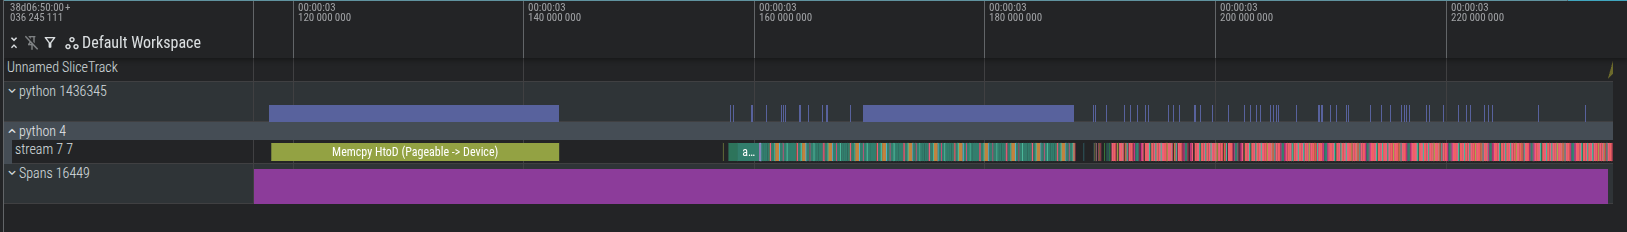
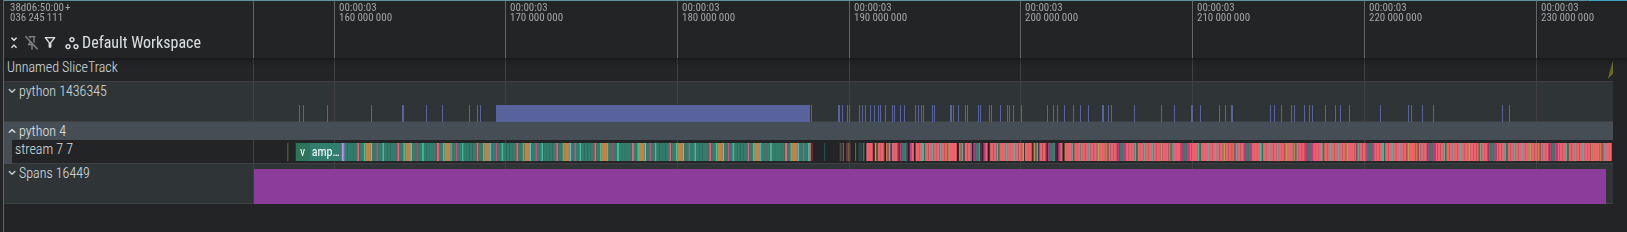

My profiler: forward 43ms, backward 50ms.
Torch profiler: memory coping 20ms, gap 15ms, forward 30ms, backward 43ms

1st inefficienciy
```
train_loader = DataLoader(dataset=train_data, batch_size=Settings.batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=Settings.batch_size, shuffle=False)
```
num_workers=32, pin_meomry=true significally increase cpu - gpu memory copying

In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch(model, train_loader, val_loader, criterion, optimizer)

Total time of epoch was: 70s, now: 10s. We dont need profiler to see difference

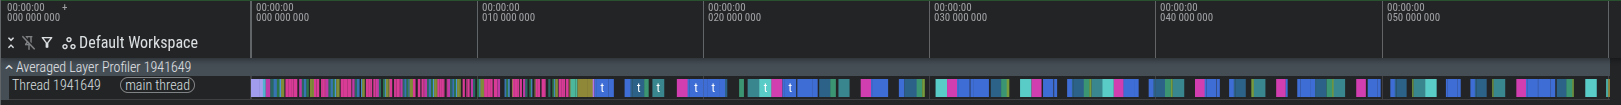

And to_path_embidding_forward was significally faster because of faster copying

2nd inefficienciy: we can use bfloat16 scaling

In [3]:
from torch.amp import autocast, GradScaler

def run_epoch_bf_16(model, train_loader, val_loader, criterion, optimizer):
    model.train()
    epoch_loss, epoch_accuracy = 0.0, 0.0
    
    with Profile(
        model,
        schedule=schedule(wait=2, warmup=1, active=3),
    ) as prof:
        scaler = GradScaler('cuda')
        for data, label in tqdm(train_loader, desc="Train"):
            data = data.to(Settings.device)
            label = label.to(Settings.device)
            with autocast('cuda', torch.bfloat16):
                output = model(data)
                loss = criterion(output, label)

            acc = (output.argmax(dim=1) == label).float().mean()
            epoch_accuracy += acc.item() / len(train_loader)
            epoch_loss += loss.item() / len(train_loader)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
    
            scaler.update()
            prof.step()
        prof.to_perfetto()

    model.eval()
    val_loss, val_accuracy = 0.0, 0.0

    for data, label in tqdm(val_loader, desc="Val"):
        data = data.to(Settings.device)
        label = label.to(Settings.device)

        with torch.no_grad():
            with autocast('cuda', torch.bfloat16):
                output = model(data)
                loss = criterion(output, label)

        acc = (output.argmax(dim=1) == label).float().mean()
        val_accuracy += acc.item() / len(val_loader)
        val_loss += loss.item() / len(val_loader)

    

    return epoch_loss, epoch_accuracy, val_loss, val_accuracy

In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch_bf_16(model, train_loader, val_loader, criterion, optimizer)

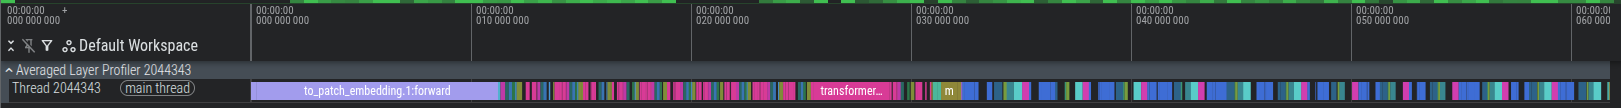

Batch cuda time was 60ms, now 52ms

3rd inefficienciy: Attention. We can calculate q, k and v in 1 matrix multiplication

```
class Attention(nn.Module):
    def __init__(self, dim, heads=8, dim_head=64, dropout=0.0):
        super().__init__()
        inner_dim = heads * dim_head
        self.heads = heads
        self.dim_head = dim_head

        self.norm = nn.LayerNorm(dim)
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias=False)
        self.dropout = dropout

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _ = x.shape
        x = self.norm(x)

        qkv = self.to_qkv(x).reshape(b, n, 3, self.heads, self.dim_head)
        q, k, v = qkv.unbind(dim=2)

        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)

        out = torch.nn.functional.scaled_dot_product_attention(
            q, k, v,
            dropout_p=self.dropout if self.training else 0.0
        )

        out = out.transpose(1, 2).reshape(b, n, self.heads * self.dim_head)
        return self.to_out(out)
```

In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch_bf_16(model, train_loader, val_loader, criterion, optimizer)

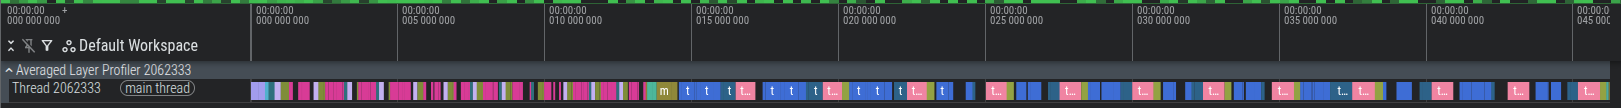
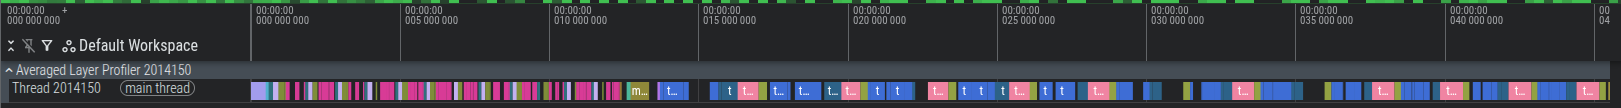

Was: 52ms, now: 47ms

In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch_bf_16(model, train_loader, val_loader, criterion, optimizer)

4th inefficienciy: 

```
self.to_patch_embedding = nn.Sequential(
    Rearrange("b c (h p1) (w p2) -> b (h w) (p1 p2 c)", p1=patch_height, p2=patch_width),
    nn.Linear(patch_dim, dim),
)
```
is equivalent to
```
self.to_patch_embedding = nn.Sequential(
    nn.Conv2d(
        in_channels=channels,
        out_channels=dim,
        kernel_size=(patch_height, patch_width),
        stride=(patch_height, patch_width),
        bias=True,
    ),
    Rearrange("b d h w -> b (h w) d"),
)
```

In [ ]:
seed_everything()
model = get_vit_model()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch_bf_16(model, train_loader, val_loader, criterion, optimizer)

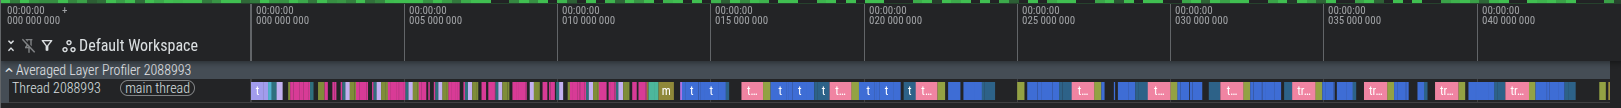

Was: 47ms, now: 45ms

5th inefficienciy:
use
```
torch.compile()
```



In [ ]:
seed_everything()
model = get_vit_model()
model.compile()
train_loader, val_loader = get_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=Settings.lr)

run_epoch_bf_16(model, train_loader, val_loader, criterion, optimizer)

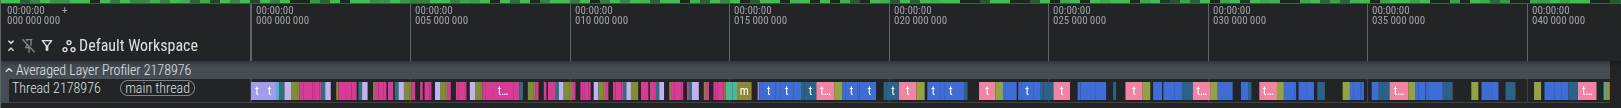

Was: 45ms, now 43ms

6th inefficienciy: tonsor sizes must be divisible by 128
```
class ViT(nn.Module):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        num_classes,
        depth,
        heads,
        dim=255 -> 256,
        pool="cls",
        channels=3,
        dim_head=64,
        dropout=0.0,
        emb_dropout=0.0,
    ):
```